<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-05-tree-based-models-bagging-quantile-regression-forest-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.5 Quantile Regression Forest (QRF)

Quantile Regression Forests (QRF) is a machine learning method that extends Random Forests to predict conditional quantiles of a response variable, rather than just the mean. It’s particularly useful for modeling the uncertainty and heterogeneity in data by estimating the full conditional distribution of the response variable, allowing you to predict specific quantiles (e.g., median, 90th percentile) instead of a single point estimate. This makes QRF valuable in applications like forecasting, risk analysis, and decision-making under uncertainty.

## Overview

Quantile Regression Forests, introduced by Meinshausen (2006), combine the principles of Random Forests (ensemble of decision trees) with quantile regression. While a standard Random Forest predicts the conditional mean of the response variable given predictors, QRF estimates the conditional quantiles (e.g., 10th, 50th, or 90th percentiles). This is achieved by maintaining the full set of observed response values in the leaf nodes of the trees and using them to approximate the conditional distribution.

QRF is particularly effective for:

- Modeling non-linear relationships.
- Capturing heteroscedasticity (varying variance in the response variable).
- Providing prediction intervals and uncertainty quantification.




### Key Features of Quantile Regression Forests

1. **Non-parametric Approach**: QRF does not assume a specific distribution for the response variable, making it robust to non-Gaussian data and outliers.
2. **Quantile Estimation**: It can estimate any quantile (e.g., τ = 0.1 for the 10th percentile, τ = 0.5 for the median) of the conditional distribution.
3. **Uncertainty Quantification**: QRF provides prediction intervals (e.g., 10th to 90th percentile) to quantify uncertainty.
4. **Handles High-Dimensional Data**: Like Random Forests, QRF can handle many predictors and complex interactions between them.
5. **Robustness**: Inherits the robustness of Random Forests to noise and irrelevant features.
6. **Flexibility**: Works well for both regression and classification problems, though it’s primarily used for regression.



### How Quantile Regression Forests Work

QRF builds on the Random Forest algorithm but modifies how predictions are made. Instead of averaging the response values in a leaf node to predict the mean, QRF retains all response values in the leaf nodes and uses them to estimate the conditional cumulative distribution function (CDF) for a given input. Quantiles are then derived from this estimated CDF.

Here’s a step-by-step explanation of how QRF works, including the relevant equations:

1. Data Preparation

- A dataset with predictors $X = \{x_1, x_2, \dots, x_n\}$ (where each $x_i$ in $\mathbb{R}^p$) and response variable $Y = \{y_1, y_2, \dots, y_n\}$.
- For a new input $x$, estimate the conditional quantiles $Q_Y(\tau | x)$, where $\tau \in (0, 1)$ is the desired quantile (e.g., $\tau = 0.5$ for the median).

The conditional quantile $Q_Y(\tau | x)$ is defined as:

$$ Q_Y(\tau | x) = \inf \{ y : P(Y \leq y | X = x) \geq \tau \} $$

This represents the value $y$ such that the probability of $Y \leq y$ given $X = x$ is at least $\tau$.

2. Build a Random Forest

QRF constructs an ensemble of decision trees using the Random Forest algorithm:

- `Bootstrap Sampling`: For each tree $t = 1, 2, \dots, T$, sample a random subset of the data (with replacement) to create a bootstrap sample.

- `Feature Subsampling`: At each node of a tree, randomly select a subset of features (e.g., $m < p$) to consider for splitting.

- `Splitting Criterion`: Use a criterion (e.g., variance reduction) to split nodes, as in standard Random Forests. The split at node $h$ minimizes:

$$ \text{Impurity} = \sum_{i \in \text{left child}} (y_i - \bar{y}_{\text{left}})^2 + \sum_{i \in \text{right child}} (y_i - \bar{y}_{\text{right}})^2 $$

where $\bar{y}_{\text{left}}$ and $\bar{y}_{\text{right}}$ are the means of the response values in the left and right child nodes, respectively.

- Each tree grows until a stopping criterion is met (e.g., minimum node size or maximum depth).

- Unlike standard Random Forests, QRF stores all response values $y_i$ for the training samples that fall into each leaf node, not just their mean.

3. Assign Weights to Observations

For a new input $x$, QRF computes the weight of each training observation $y_i$ based on its proximity to $x$ in the forest:

- For each tree $t$, identify the leaf node  $L_t(x)$ that $x$ falls into.

- Assign a weight $w_i(x)$ to each training observation $y_i$ based on whether it falls into the same leaf as \( x \) across all trees:

$$ w_i(x) = \frac{1}{T} \sum_{t=1}^T \mathbb{I}\{ (x_i, y_i) \in L_t(x) \} $$

where $\mathbb{I}\{ \cdot \}$ is the indicator function (1 if the condition is true, 0 otherwise), and $L_t(x)$ is the leaf node in tree $t$ containing $x$. The weight $w_i(x)$ represents the average proportion of trees where $x_i$ and $x$ share the same leaf.

4. Estimate the Conditional CDF

Using the weights $w_i(x)$, QRF approximates the conditional cumulative distribution function (CDF) of $Y$ given $X = x$:

$$ \hat{F}(y | x) = \sum_{i=1}^n w_i(x) \mathbb{I}\{ y_i \leq y \} $$

This is a weighted empirical CDF, where each observation $y_i$ contributes to the CDF based on its weight $w_i0(x)$.

5. Compute Conditional Quantiles

To estimate the conditional quantile $Q_Y(\tau | x)$ for a given $\tau$, find the value $y$ such that the estimated CDF reaches or exceeds $\tau$:

$$ \hat{Q}_Y(\tau | x) = \inf \{ y : \hat{F}(y | x) \geq \tau \} $$

In practice, this is computed by sorting the response values $y_i$ with non-zero weights $w_i(x)$ and finding the value $y$ where the cumulative sum of weights reaches $\tau$.

For example:

- Sort the $y_i$ values in ascending order: $y_{(1)} \leq y_{(2)} \leq \dots \leq y_{(n)}$.

- Compute the cumulative weights: $\sum_{i: y_i \leq y_{(k)}} w_i(x)$.

- Find the smallest $y_{(k)}$ such that $\sum_{i: y_i \leq y_{(k)}} w_i(x) \geq \tau$.

6. Prediction Intervals (Optional)

To construct a prediction interval (e.g., 80% interval), compute the quantiles for $\tau = 0.1$ and $\tau = 0.9$:

$$ \hat{Q}_Y(0.1 | x), \hat{Q}_Y(0.9 | x) $$

This interval captures the central 80% of the conditional distribution of $Y$.

7. Output

For a given input $x$, QRF outputs:

- The estimated quantiles $\hat{Q}_Y(\tau | x)$ for specified $\tau$ (e.g., median for $\tau = 0.5$).

- Optionally, prediction intervals or the full conditional distribution.



Below is a flowchart summarizing the QRF algorithm:


![alt text](http://drive.google.com/uc?export=view&id=1l61dWCA6kQkFf7Q2-hNZEu78cc8Z-flu)


### QRF Differs from Standard Random Forests

- **Standard Random Forest**: Predicts the conditional mean \( \mathbb{E}[Y | X = x] \) by averaging the response values in the leaf nodes.
- **QRF**: Retains all response values in the leaf nodes and uses them to estimate the conditional CDF, allowing quantile predictions.


### Advantages and Limitations

**Advantages**:

- Provides a full picture of the conditional distribution, not just the mean.
- Handles complex, non-linear relationships without distributional assumptions.
- Robust to outliers and heteroscedasticity.
- Can generate prediction intervals for uncertainty quantification.

**Limitations**:

- Computationally intensive, especially for large datasets, as it stores all response values in leaf nodes.
- Interpretability is limited compared to simpler models like linear quantile regression.
- Performance depends on the quality and diversity of the Random Forest ensemble.






### Applications

- **Finance**: Estimating quantiles of asset returns for risk management (e.g., Value-at-Risk).
- **Environmental Science**: Predicting extreme weather events (e.g., 95th percentile of rainfall).
- **Healthcare**: Modeling variability in patient outcomes.
- **Energy**: Forecasting energy demand with uncertainty intervals.




## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314977 sha256=f14b06bfed662680267b2fc775ddca840373e7d6b94cf7461e76e621064dfbb1
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Quantile Regression Forest from scratch

Implementing a QRF model from scratch in base R is highly complex because Random Forests (and by extension, QRF) rely on ensemble tree-building and randomization techniques that are typically handled by packages like {randomForest} or {quantregForest}. Without packages, we would need to manually code decision tree construction, bootstrap sampling, random feature selection, and quantile estimation, which is impractical for a concise response and computationally intensive.

However, I can provide a conceptual implementation of a simplified QRF in base R, focusing on the core mechanics, and then use the provided data to fit and validate the model. To make this feasible, I’ll approximate the QRF by building a small ensemble of decision trees and estimating quantiles manually.


### Data

In [6]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(MASS)
library(dplyr)
library(plyr)

# Load data
data("Boston")
# Create a data frame with selected variables
df <- Boston %>%
  dplyr::select(medv, crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, black, lstat)

# Convert chas to factor (categorical variable)
df$chas <- as.factor(df$chas)

# Convert rad and tax to numeric
df$rad <- as.numeric(df$rad)
df$tax <- as.numeric(df$tax)

# Split data into training (70%) and test (30%) sets, stratified by chas
seeds <- 11076
tr_prop <- 0.70
set.seed(seeds)

# Stratified sampling
train <- ddply(df, .(chas),
               function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] },
               seed = seeds)
test <- ddply(df, .(chas),
              function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] },
              seed = seeds)

# Scale the numeric features (exclude medv and chas)
numeric_cols <- c("crim", "zn", "indus", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "black", "lstat")
train[numeric_cols] <- scale(train[numeric_cols])
test[numeric_cols] <- scale(test[numeric_cols])

# Define train_X, train_y, test_X, test_y
train_X <- train %>% dplyr::select(-medv)
train_y <- train$medv
test_X <- test %>% dplyr::select(-medv)
test_y <- test$medv

### Simplified QRF Implementation Function

The R function `build_simple_tree()` constructs a simplified decision tree for regression, used in Quantile Regression Forests.

- **Inputs**:
  - `X`: Data frame of predictors.
  - `y`: Response vector.
  - `n_features`: Number of features to consider.

- **Steps**:
  1. Validates `X` as a data frame.
  2. Randomly selects `n_features` features.
  3. For each feature and its unique values (as thresholds):
     - Splits data into left (`<= threshold`) and right (`> threshold`) groups.
     - Computes weighted variance: `(var(left_y) * left_size + var(right_y) * right_size) / n`.
     - Keeps split with lowest variance.
  4. Returns a list: best feature, threshold, loss, and response values (`left_y`, `right_y`).

- **Key Features**:
  - Random feature selection.
  - Variance-based splitting.
  - Stores response values for quantile estimation.

- **Limitations**:
  - No recursion or stopping criteria.
  - Regression-focused.

Used to build trees in QRF for quantile predictions.

In [7]:
%%R
# Simplified decision tree function
build_simple_tree <- function(X, y, n_features) {
  if (!is.data.frame(X)) stop("X must be a data frame")
  n <- nrow(X)
  selected_features <- sample(1:ncol(X), size = min(n_features, ncol(X)))
  best_split <- list(feature = NULL, threshold = NULL, loss = Inf, left_y = NULL, right_y = NULL)

  for (feature in selected_features) {
    feature_values <- as.numeric(X[[feature]])
    values <- sort(unique(feature_values))
    if (length(values) < 2) next
    for (threshold in values[-length(values)]) {
      left_idx <- feature_values <= threshold
      right_idx <- !left_idx
      if (sum(left_idx) > 0 & sum(right_idx) > 0) {
        left_y <- y[left_idx]
        right_y <- y[right_idx]
        # Fixed syntax: Added parentheses to var() calls
        loss <- var(left_y, na.rm = TRUE) * sum(left_idx) / n + var(right_y, na.rm = TRUE) * sum(right_idx) / n
        if (!is.na(loss) && loss < best_split$loss) {
          best_split <- list(
            feature = feature,
            threshold = threshold,
            loss = loss,
            left_y = left_y,
            right_y = right_y
          )
        }
      }
    }
  }
  return(best_split)
}

### QRF model

This R code builds a Quantile Regression Forest (QRF) by creating an ensemble of decision trees:

- **Inputs**: `train_X` (predictors), `train_y` (response), `n_trees` (10 trees), `n_features` (3 features per split).
- **Process**:
  1. Loops `n_trees` times.
  2. For each tree:
     - Randomly samples data with replacement (`boot_idx`).
     - Creates bootstrap subsets `boot_X` and `boot_y`.
     - Builds a tree using `build_simple_tree` with `n_features`.
     - Stores the tree in `trees` list.
- **Output**: List of `n_trees` trees for QRF predictions.

In [8]:
%%R
# QRF model (ensemble of simple trees)
n_trees <- 10  # Small number for simplicity
n_features <- 3  # Number of features to consider at each split
trees <- list()
# Build trees
for (i in 1:n_trees) {
  boot_idx <- sample(1:nrow(train_X), size = nrow(train_X), replace = TRUE)
  boot_X <- train_X[boot_idx, , drop = FALSE]
  boot_y <- train_y[boot_idx]
  tree <- build_simple_tree(boot_X, boot_y, n_features)
  trees[[i]] <- tree
}


### Prediction Function

The R function `predict_qrf` predicts quantiles for new data using a Quantile Regression Forest (QRF):

- **Inputs**: `X_new` (new predictors), `trees` (list of QRF trees), `quantiles` (e.g., 0.1, 0.5, 0.9).
- **Process**:
  1. Initializes a matrix for predictions (rows = samples, columns = quantiles).
  2. For each sample in `X_new`:
     - Collects response values (`left_y` or `right_y`) from each tree’s leaf based on feature and threshold.
     - Computes specified quantiles from collected values.
     - Assigns NA if no values are collected.
  3. Names columns (e.g., "q0.1", "q0.5", "q0.9").
- **Output**: Matrix of quantile predictions for each sample.

In [9]:
%%R
# Prediction function for quantiles
predict_qrf <- function(X_new, trees, quantiles = c(0.1, 0.5, 0.9)) {
  n <- nrow(X_new)
  predictions <- matrix(NA, nrow = n, ncol = length(quantiles))

  for (i in 1:n) {
    collected_y <- c()
    for (tree in trees) {
      if (is.null(tree$feature)) next
      feature <- tree$feature
      threshold <- tree$threshold
      if (as.numeric(X_new[i, feature]) <= threshold) {
        collected_y <- c(collected_y, tree$left_y)
      } else {
        collected_y <- c(collected_y, tree$right_y)
      }
    }
    if (length(collected_y) > 0) {
      predictions[i, ] <- quantile(collected_y, probs = quantiles, na.rm = TRUE)
    } else {
      predictions[i, ] <- NA
    }
  }
  colnames(predictions) <- paste0("q", quantiles)
  return(predictions)
}

### Model Evaluation

**Quantile Loss** (also called pinball loss) is a loss function used in quantile regression to measure the error between true values and predicted quantiles. It penalizes under- and over-predictions asymmetrically based on the target quantile $\tau \in (0, 1)$). For a quantile $\tau$, the loss encourages the prediction to align with the $\tau$-th percentile of the data.

$$ L_{\tau}(y_{\text{true}}, y_{\text{pred}}) =
  \begin{cases}
  \tau \cdot (y_{\text{true}} - y_{\text{pred}}) & \text{if } y_{\text{true}} \geq y_{\text{pred}}, \\
  (1 - \tau) \cdot (y_{\text{pred}} - y_{\text{true}}) & \text{if } y_{\text{true}} < y_{\text{pred}}.
  \end{cases}
  $$

In Quantile Regression Forests, quantile loss isn’t directly used for tree building (which uses variance reduction), but it’s useful for evaluating the accuracy of quantile predictions or fine-tuning models.

In [10]:
%%R
# Predict on test set
quantiles <- c(0.1, 0.5, 0.9)  # Define quantiles explicitly
test_predictions <- predict_qrf(test_X, trees, quantiles)

# Validation using quantile loss
quantile_loss <- function(y_true, y_pred, tau) {
  errors <- y_true - y_pred
  loss <- mean(ifelse(errors >= 0, tau * errors, (tau - 1) * errors), na.rm = TRUE)
  return(loss)
}

# Calculate quantile loss for each quantile
losses <- sapply(1:ncol(test_predictions), function(i) {
  quantile_loss(test_y, test_predictions[, i], quantiles[i])
})
names(losses) <- paste0("q", quantiles)

# Print results
cat("Test Quantile Predictions (first 5 rows):\n")
print(head(test_predictions))
cat("\nQuantile Losses:\n")
print(losses)


Test Quantile Predictions (first 5 rows):
     q0.1 q0.5 q0.9
[1,] 13.4 20.6 32.4
[2,] 13.4 20.6 32.4
[3,] 13.1 20.1 29.9
[4,] 13.1 20.1 29.9
[5,] 13.1 20.1 29.9
[6,] 13.1 20.1 29.9

Quantile Losses:
    q0.1     q0.5     q0.9 
1.261353 2.976307 1.538065 


## Quantile Regression Forest in R

Quantile Regression Forest extends Random Forests to estimate conditional quantiles, providing a robust, non-parametric way to model the full distribution of a response variable. It works by collecting observations from tree leaves and computing quantiles from the empirical distribution. It’s particularly valuable for applications requiring uncertainty quantification or modeling non-standard distributions.

The {quantregForest} package in R is designed for fitting Quantile Regression Forests (QRF), an extension of Random Forests that predicts conditional quantiles of a response variable instead of just the mean. It allows users to estimate the full conditional distribution, making it ideal for modeling uncertainty, variability, or heteroskedasticity. The package provides functions to train QRF models, predict quantiles (e.g., 10th, 50th, 90th percentiles), and assess variable importance. It is particularly useful for non-parametric regression tasks in fields like ecology, finance, and risk assessment.

The **{quantregForest}** package in R provides several key functions for building and analyzing Quantile Regression Forests (QRF). Below are the most important functions, based on the package's documentation and common usage:

1.  `quantregForest()`: Constructs an ensemble of decision trees to estimate conditional quantiles of the response variable, retaining all observations in leaf nodes to compute quantiles.

    -   **Key Arguments**:
        -   `x`: Matrix or data frame of predictor variables.\
        -   `y`: Vector of response variable values.\
        -   `ntree`: Number of trees in the forest (default: 500).\
        -   `mtry`: Number of predictors to consider at each split (default: `floor(ncol(x)/3)`).\
        -   `nodesize`: Minimum number of observations in a terminal node (default: 5).\
        -   `importance`: Logical to compute variable importance (default: FALSE).

2.  `predict.quantregForest()`: \*: Makes predictions for specified quantiles using a fitted QRF model. Generates quantile predictions (e.g., 10th, 50th, 90th percentiles) for new data based on the empirical distribution of responses in the leaf nodes.

    -   **Key Arguments**:
        -   `object`: A fitted `quantregForest` model.\
        -   `newdata`: Data frame or matrix of predictors for which to predict quantiles.\
        -   `what`: Vector of quantiles to predict (e.g., `c(0.1, 0.5, 0.9)`) or a function (e.g., `mean` for conditional mean).\
        -   `all`: Logical to return predictions for all trees (default: FALSE).

3.  `importance.quantregForest()`: Extracts variable importance measures from a fitted QRF model.

    -   **Key Arguments**:
        -   `x`: A fitted `quantregForest` model with `importance = TRUE`.

4.  `conditionalQuantiles()`: Estimates conditional quantiles for specific predictor values.

    -   **Key Arguments**:
        -   `object`: A fitted `quantregForest` model.\
        -   `newdata`: Data for which to compute quantiles.\
        -   `quantiles`: Vector of quantiles to estimate (e.g., `c(0.1, 0.5, 0.9)`).

These functions make {quantregForest} a powerful tool for non-parametric quantile regression, particularly for applications requiring uncertainty quantification or robust predictions.


### Load and Check Required Libraries

In [11]:
%%R
packages <- c('tidyverse',
              'plyr',
              'quantregForest',
              'mlbench',
              'Metrics',
              'MASS'
         )

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [12]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
     tidyverse           plyr quantregForest        mlbench        Metrics 
          TRUE           TRUE           TRUE           TRUE           TRUE 
          MASS 
          TRUE 


### Load R Packages

In [13]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

### Check Loaded Packages

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:Metrics"        "package:mlbench"        "package:quantregForest"
 [4] "package:RColorBrewer"   "package:randomForest"   "package:plyr"          
 [7] "package:lubridate"      "package:forcats"        "package:stringr"       
[10] "package:dplyr"          "package:purrr"          "package:readr"         
[13] "package:tidyr"          "package:tibble"         "package:ggplot2"       
[16] "package:tidyverse"      "package:tools"          "package:stats"         
[19] "package:graphics"       "package:grDevices"      "package:utils"         
[22] "package:datasets"       "package:methods"        "package:base"          


### Data


In [14]:
%%R

# Load data
data("Boston")
# Create a data frame with selected variables
df <- Boston %>%
  dplyr::select(medv, crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, black, lstat)

# Convert chas to factor (categorical variable)
df$chas <- as.factor(df$chas)

# Convert rad and tax to numeric
df$rad <- as.numeric(df$rad)
df$tax <- as.numeric(df$tax)

# Split data into training (70%) and test (30%) sets, stratified by chas
seeds <- 11076
tr_prop <- 0.70
set.seed(seeds)

# Stratified sampling
train <- ddply(df, .(chas),
               function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] },
               seed = seeds)
test <- ddply(df, .(chas),
              function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] },
              seed = seeds)

# Scale the numeric features (exclude medv and chas)
numeric_cols <- c("crim", "zn", "indus", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "black", "lstat")
train[numeric_cols] <- scale(train[numeric_cols])
test[numeric_cols] <- scale(test[numeric_cols])

# Define train_X, train_y, test_X, test_y
X_train<- train %>% dplyr::select(-medv)
y_train <- train$medv
X_test <- test %>% dplyr::select(-medv)
y_test <- test$medv

### Fit Quantile Regression Forest

`quantregForest()` function from the {quantregForest} package is used to fit a Quantile Regression Forest model. It builds an ensemble of decision trees to estimate conditional quantiles of the response variable, retaining all observations in leaf nodes to compute quantiles.

In [15]:
%%R
# Fit Quantile Regression Forest

set.seed(seeds)
qrf_model <- quantregForest(x = X_train, y = y_train,
                           ntree = 500,
                           nodesize = 5,
                           mtry = floor(ncol(X_train)/3),
                           importance = TRUE)
qrf_model


 Call:
 quantregForest(x = X_train, y = y_train, ntree = 500, nodesize = 5,      mtry = floor(ncol(X_train)/3), importance = TRUE) 

                     Number of trees: 500
No. of variables tried at each split: 4



### Prediction and Evaluation

In [16]:
%%R
# Predict quantiles (10th, 50th, 90th percentiles)
quantiles <- c(0.10, 0.50, 0.90)
qrf_predictions <- predict(qrf_model, newdata = X_test, what = quantiles)

# Evaluate model performance
# Function to calculate RMSE for a specific quantile
calc_rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2))
}

# Calculate RMSE for each quantile
rmse_results <- sapply(1:length(quantiles), function(i) {
  calc_rmse(y_test, qrf_predictions[, i])
})

# Print RMSE for each quantile
names(rmse_results) <- paste0("Quantile_", quantiles)
print("RMSE for each quantile:")
print(rmse_results)

# Calculate coverage for 80% prediction interval (10th to 90th percentile)
coverage <- mean(y_test >= qrf_predictions[, 1] & y_test <= qrf_predictions[, 3])
cat("Coverage of 80% prediction interval:", coverage, "\n")

[1] "RMSE for each quantile:"
Quantile_0.1 Quantile_0.5 Quantile_0.9 
    7.141435     4.303445     6.778992 
Coverage of 80% prediction interval: 0.9281046 


### Variable Importance

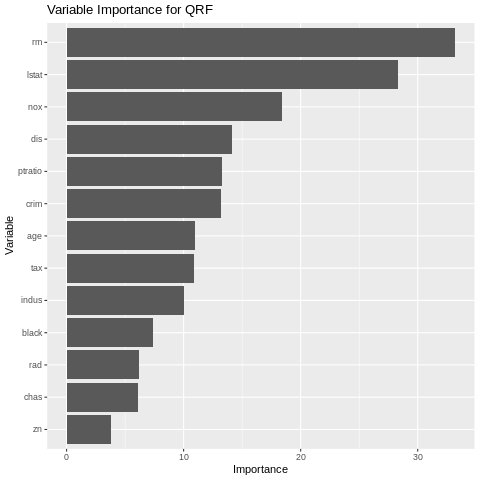

In [17]:
%%R
# Variable importance
var_imp_qrf <- importance(qrf_model)
var_imp_qrf <- sort(var_imp_qrf[,1], decreasing = TRUE) # Sort by importance
var_imp_qrf <- data.frame(Variable = names(var_imp_qrf), Importance = var_imp_qrf)
# plot variable importance
ggplot(var_imp_qrf, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Variable Importance for QRF", x = "Variable", y = "Importance")


### Hyperparameter Tuning

To perform hyperparameter tuning for the `quantregForest` model in R,  we can implement a custom grid search with k-fold cross-validation. We'll use the provided data processing code and the `quantile_loss` function to evaluate performance, focusing on optimizing `ntree`, `nodesize`, and `mtry`. Below is a concise R code for hyperparameter tuning using base R and parallel processing with `doParallel`.

Steps for Hyperparameter Tuning:

1. **Define Parameter Grid**: Create combinations of `ntree`, `nodesize`, and `mtry`.
2. **Custom Cross-Validation**: Implement k-fold CV manually to compute quantile loss for each parameter set.
3. **Select Best Parameters**: Choose the combination with the lowest average quantile loss.
4. **Train Final Model**: Use the best parameters to train the QRF model.
5. **Evaluate on Test Set**: Compute quantile losses for multiple quantiles on the test set.


#### Define quantile loss function

In [18]:
%%R
# Define quantile loss function
quantile_loss <- function(y_true, y_pred, tau) {
  errors <- y_true - y_pred
  loss <- mean(ifelse(errors >= 0, tau * errors, (tau - 1) * errors), na.rm = TRUE)
  return(loss)
}

#### Define Parameter Grid

In [19]:
%%R
# Define parameter grid
param_grid <- expand.grid(
  ntree = c(100, 500, 1000),
  nodesize = c(5, 10, 15),
  mtry = c(floor(ncol(X_train)/4), floor(ncol(X_train)/3), floor(ncol(X_train)/2))
)

#### Custom k-fold Cross-Validation Function

In [20]:
%%R
# Custom k-fold cross-validation function
qrf_cv <- function(params, x, y, k = 5, tau = 0.5, seed = seeds) {
  set.seed(seed)
  n <- length(y)
  folds <- sample(rep(1:k, length.out = n))
  losses <- numeric(k)

  for (fold in 1:k) {
    train_idx <- which(folds != fold)
    val_idx <- which(folds == fold)

    x_tr <- x[train_idx, ]
    y_tr <- y[train_idx]
    x_val <- x[val_idx, ]
    y_val <- y[val_idx]

    model <- quantregForest(
      x = x_tr, y = y_tr,
      ntree = params$ntree,
      nodesize = params$nodesize,
      mtry = params$mtry
    )

    pred <- predict(model, newdata = x_val, what = tau)
    losses[fold] <- quantile_loss(y_val, pred, tau)
  }

  return(mean(losses))
}

#### Perform Grid Search

In [21]:
%%R
# Perform grid search
results <- data.frame(param_grid, loss = NA)
for (i in 1:nrow(param_grid)) {
  params <- param_grid[i, ]
  results$loss[i] <- qrf_cv(params, X_train, y_train, k = 5, tau = 0.5, seed = seeds)
}

#### Best Parameters

In [22]:
%%R
# Find best parameters
best_params <- results[which.min(results$loss), ]
cat("Best Parameters:\n")
print(best_params)

Best Parameters:
   ntree nodesize mtry     loss
19   100        5    6 1.097646


#### Train Final Model with Best Parameters

In [23]:
%%R
# Train final model with best parameters
set.seed(seeds)
final_qrf_model <- quantregForest(
  x = X_train, y = y_train,
  ntree = as.numeric(best_params$ntree),
  nodesize = as.numeric(best_params$nodesize),
  mtry = as.numeric(best_params$mtry),
  importance = TRUE
)

### Predict and Evaluate on Test Set

In [24]:
%%R
# Predict on test set for multiple quantiles
quantiles <- c(0.1, 0.5, 0.9)
test_pred <- predict(final_qrf_model, newdata = X_test, what = quantiles)
colnames(test_pred) <- paste0("q", quantiles)

# Evaluate test set performance
test_losses <- sapply(seq_along(quantiles), function(i) {
  quantile_loss(y_test, test_pred[, i], quantiles[i])
})
names(test_losses) <- paste0("q", quantiles)
cat("Test Set Quantile Losses:\n")
print(test_losses)

Test Set Quantile Losses:
     q0.1      q0.5      q0.9 
0.5408366 1.3014706 0.5339216 


## Summary and Conclusion

Quantile Regression Forest extends Random Forests to estimate conditional quantiles, providing a robust, non-parametric way to model the full distribution of a response variable. It works by collecting observations from tree leaves and computing quantiles from the empirical distribution. It’s particularly valuable for applications requiring uncertainty quantification or modeling non-standard distributions. This tutorial  demonstrated how to implement QRF from scratch, fit a model using the {quantregForest} package, and perform hyperparameter tuning with k-fold cross-validation. The results showed how to predict quantiles and evaluate model performance using quantile loss.

### References

1.  Meinshausen, N. (2006). Quantile Regression Forests. Journal of Machine Learning Research, 7, 983–999.

2.  Athey, S., Tibshirani, J., & Wager, S. (2019). Generalized Random Forests. The Annals of Statistics, 47(2), 1148–1178

3.  Koenker, R., & Bassett, G. (1978). Regression Quantiles. Econometrica, 46(1), 33–50.

4.  Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5–32.

5.  Zhang, H., Zimmerman, J., Nettleton, D., & Nordman, D. J. (2019). Random Forest Prediction Intervals. The American Statistician, 74(4), 392–406.

6.  [Quantile Regression Forests for Prediction Intervals \| R-bloggers](URL:%20https://www.r-bloggers.com/2021/04/quantile-regression-forests-for-prediction-intervals/)

7.  [Quantile Regression Forests Example from RDocumentation](URL:%20https://www.rdocumentation.org/packages/quantregForest/versions/1.0/topics/quantregForest)
